In [1]:
from typing import List, Iterable

import numpy as np
import matplotlib.pyplot as plt

## Часть 1. Градиентный спуск (5 баллов)

Для начала давайте вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

Ниже приведён базовый класс `BaseLoss`, который мы будем использовать для реализации всех наших лоссов. Менять его не нужно. У него есть два абстрактных метода:
1. Метод `calc_loss`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения лосса
2. Метод `calc_grad`, который будет принимать на вход объекты `x`, правильные ответы `y` и веса `w` и вычислять значения градиента (вектор)

In [2]:
import abc

class BaseLoss(abc.ABC):
    """Базовый класс лосса"""
    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        raise NotImplementedError

Теперь давайте напишем реализацию этого абстрактоного класса: Mean Squared Error лосс.

<h2>Задание 1.1 (5/8 балла):</h2>

Реализуйте класс MSELoss

Он должен вычислять лосс и градиент по формулам наверху

In [3]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: число -- значения функции потерь
        """
        return ((((X @ w) - y)**2).sum()) / X.shape[0]
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :return: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        return (2 * X.transpose() @ (X @ w - y)) / X.shape[0]

Теперь мы можем создать объект MSELoss и при помощи него вычислять значение нашей функции потерь и градиенты:

In [4]:
# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(loss.calc_grad(X, y, w), np.array([1163180., 1172281., 1181382., 1190483., 
                                                      1199584., 1208685., 1217786., 1226887., 
                                                      1235988., 1245089.])), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

<h2>Задание 1.2 (5/8 балла):</h2>

Реализуйте функцию `gradient_descent`

Функция должна принимать на вход начальное значение весов линейной модели `w_init`, матрицу объектов-признаков `X`, 
вектор правильных ответов `y`, объект функции потерь `loss`, размер шага `lr` и количество итераций `n_iterations`.

Функция должна реализовывать цикл, в котором происходит шаг градиентного спуска (градиенты берутся из `loss` посредством вызова метода `calc_grad`) по формуле выше и возвращать 
траекторию спуска (список из новых значений весов на каждом шаге)

In [5]:
def gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, n_iterations: int = 100000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    # -- YOUR CODE HERE --
    trace = [w_init]
    for elem in range(n_iterations):
        grad = loss.calc_grad(X, y, trace[-1])
        w_new = trace[-1] - lr * grad
        trace.append(w_new)
        
    return trace

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [6]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features, ))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [7]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.58917680450253
0.8670644395649493


In [8]:
def plot_gd(w_list: Iterable, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """
    Функция для отрисовки траектории градиентного спуска
    :param w_list: Список из объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать лосс при помощи loss.calc_loss(X, y, w)
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 8))
    plt.title("GD trajectory")
    plt.xlabel(r'$w_1$')
    plt.ylabel(r'$w_2$')
    plt.xlim(w_list[:, 0].min() - 0.1, 
             w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1,
             w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect('equal')

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8)

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

<h2>Задание 1.3 (5/8 балла):</h2>

При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. 

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

Подсказки:
* Функция `gradient_descent` возвращает историю весов, которую нужно подать в функцию `plot_gd`
* Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

lr =  0.0005


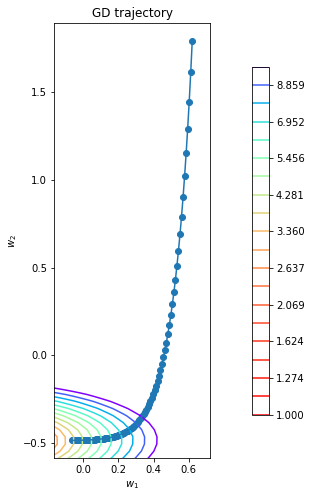

lr =  0.001


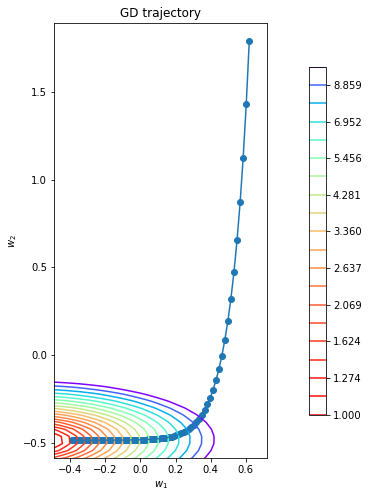

lr =  0.01


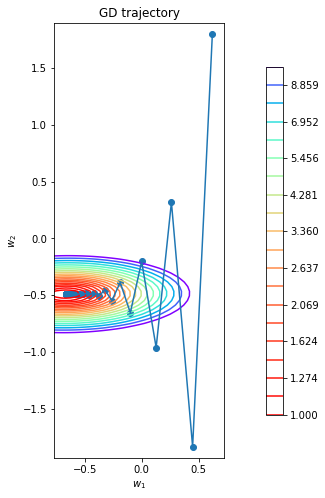

lr =  0.011


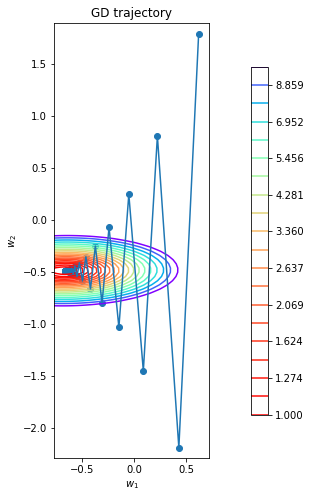

In [9]:
lr = [0.0005, 0.001, 0.01, 0.011]
for step in lr:
    trace = gradient_descent(w_init, X, y, loss, step, 100)
    print('lr = ', step)
    plot_gd(trace, X, y, loss)

Как мы видим, если взять слишком маленьое значение длины шага, то мы можем не дойти до минимума. Если же взять слишком большое значение, то градиентный спуск начинает расходится (при значении > 0.1). Оптимально брать значения больше 0.001, но меньше 0.1.

<h2>Задание 1.4 (5/8 балла):</h2>

Реализуйте функцию `stochastic_gradient_descent`

Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча. 

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [10]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, p: float, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    # -- YOUR CODE HERE --
    trace = [w_init]
    for elem in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        sample_x = X[batch_indices]
        sample_y = y[batch_indices]
        grad = loss.calc_grad(sample_x, sample_y, trace[-1])
        w_new = trace[-1] - lr * grad
        trace.append(w_new)
        
    return trace

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:
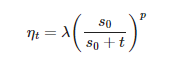


<h1>Задание 1.5 (5/8 балла):</h1>

При помощи функций `stochastic_gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`. 

Сделайте и опишите свои выводы о том, как параметры  `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

lr =  0.0005 batch_size =  1


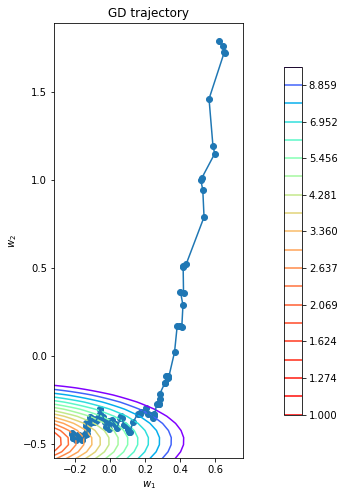

lr =  0.0005 batch_size =  10


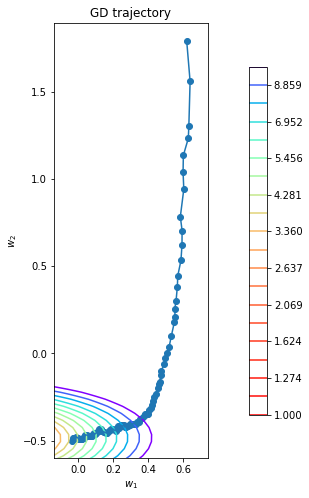

lr =  0.0005 batch_size =  30


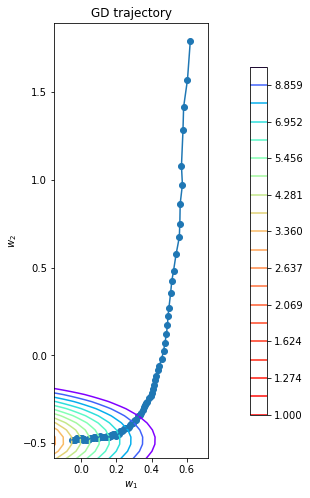

lr =  0.0005 batch_size =  100


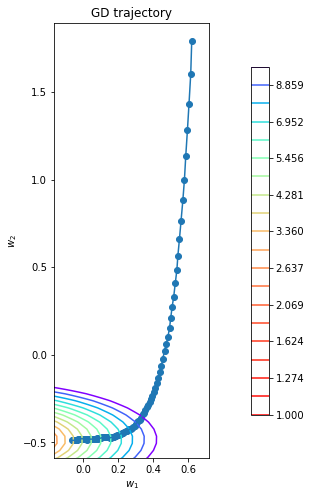

lr =  0.0005 batch_size =  175


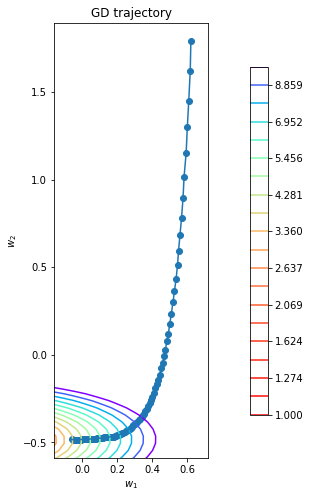

lr =  0.001 batch_size =  1


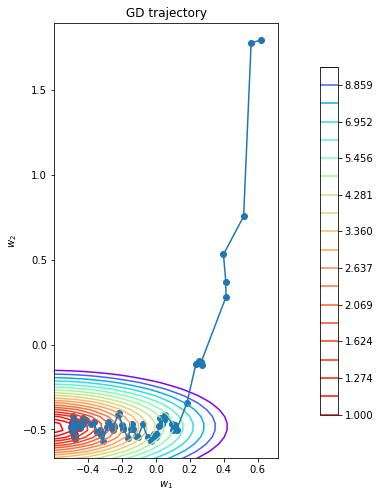

lr =  0.001 batch_size =  10


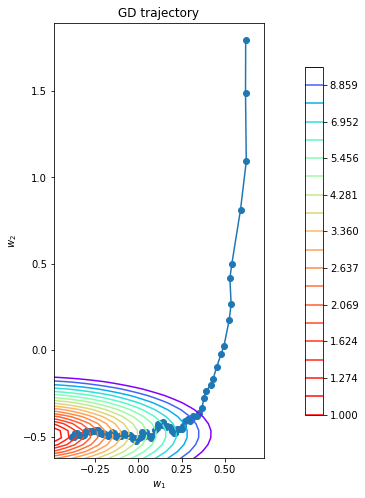

lr =  0.001 batch_size =  30


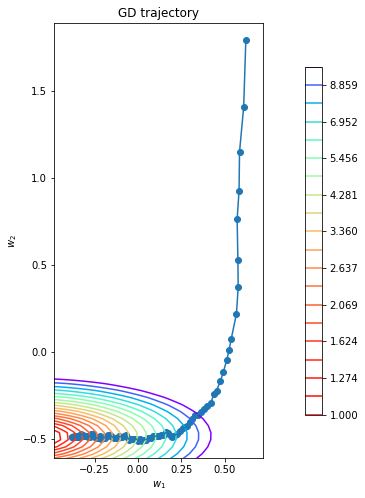

lr =  0.001 batch_size =  100


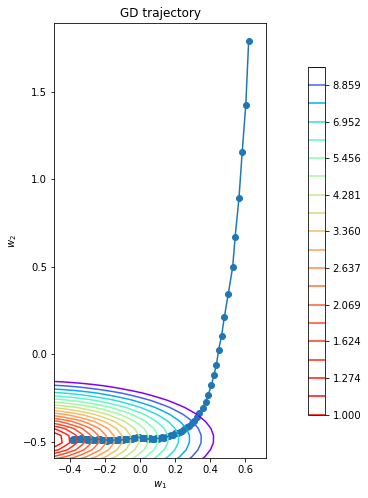

lr =  0.001 batch_size =  175


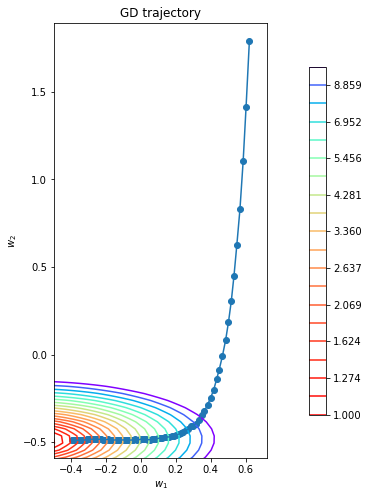

lr =  0.01 batch_size =  1


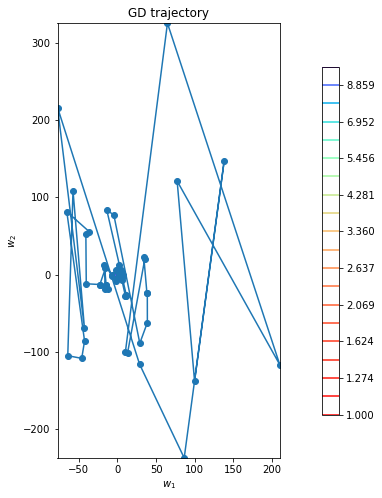

lr =  0.01 batch_size =  10


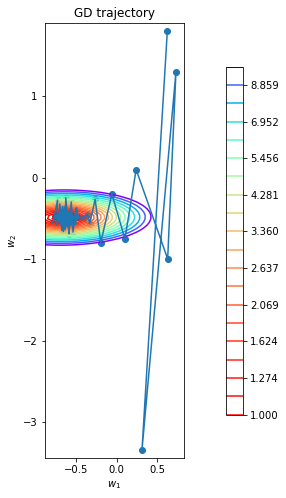

lr =  0.01 batch_size =  30


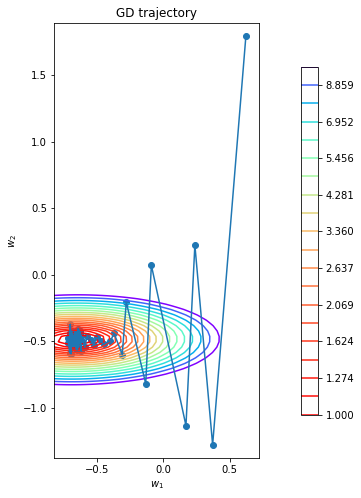

lr =  0.01 batch_size =  100


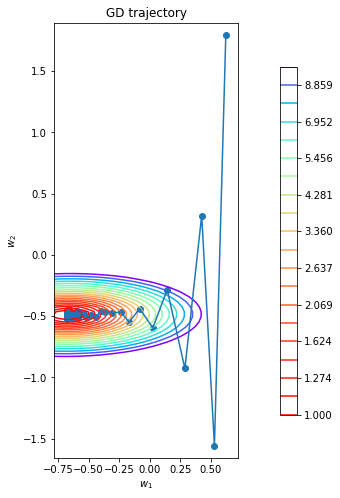

lr =  0.01 batch_size =  175


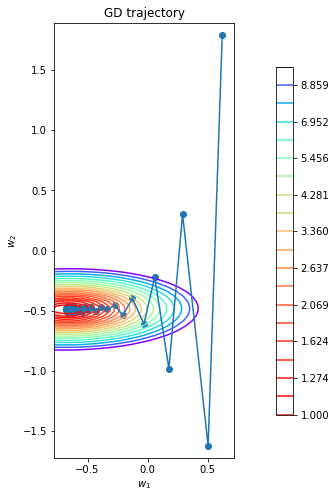

lr =  0.011 batch_size =  1


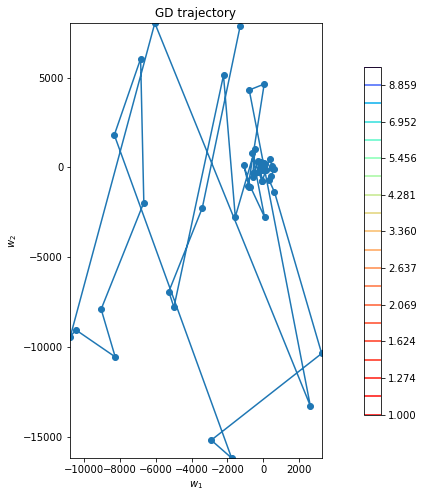

lr =  0.011 batch_size =  10


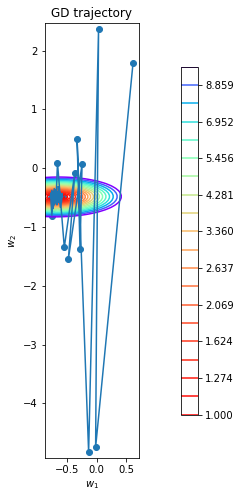

lr =  0.011 batch_size =  30


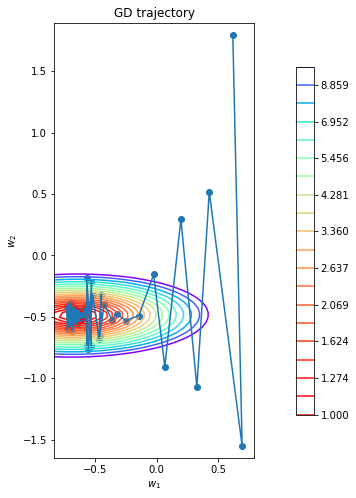

lr =  0.011 batch_size =  100


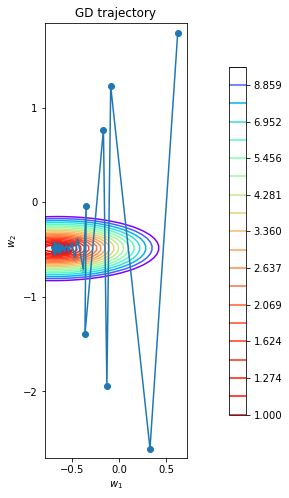

lr =  0.011 batch_size =  175


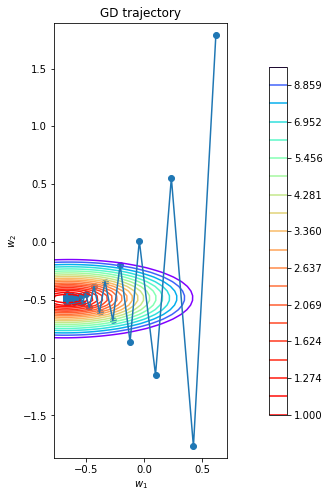

In [11]:
lr = [0.0005, 0.001, 0.01, 0.011]
batch_size = [1, 10, 30, 100, 175]
for l in lr:
    for b in batch_size:
        trace = stochastic_gradient_descent(w_init, X, y, loss, l, b, 0.01, 100)
        print('lr = ', l, "batch_size = ", b)
        plot_gd(trace, X, y, loss)

Если мы возьмем маленький шаг, то градиент может не сойтись к минимуму. Если взять большой шаг, но маленький батч, то он будет сильно колебаться. Нужно подбирать "средний" шаг и не слишком большой размер батча, тогда SGD будет похож на GD.

<h2>Задание 1.6 (5/8 балла):</h2>

Реализуйте функцию `stochastic_gradient_descent` на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [3]:
def stochastic_gradient_descent(w_init: np.ndarray, X: np.ndarray, y: np.ndarray, 
                        loss: BaseLoss, lr: float, batch_size: int, p: float, n_iterations: int = 1000) -> List[np.ndarray]:
    """
    Функция градиентного спуска
    :param w_init: np.ndarray размера (n_feratures,) -- начальное значение вектора весов
    :param X: np.ndarray размера (n_objects, n_features) -- матрица объекты-признаки
    :param y: np.ndarray размера (n_objects,) -- вектор правильных ответов
    :param loss: Объект подкласса BaseLoss, который умеет считать градиенты при помощи loss.calc_grad(X, y, w)
    :param lr: float -- параметр величины шага, на который нужно домножать градиент
    :param batch_size: int -- размер подвыборки, которую нужно семплировать на каждом шаге
    :param p: float -- значение степени в формуле затухания длины шага
    :param n_iterations: int -- сколько итераций делать
    :return: Список из n_iterations объектов np.ndarray размера (n_features,) -- история весов на каждом шаге
    """
    # -- YOUR CODE HERE --
    trace = [w_init]
    for elem in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        sample_x = X[batch_indices]
        sample_y = y[batch_indices]
        grad = loss.calc_grad(sample_x, sample_y, trace[-1])
        new_lr = lr * (1 / (1 + elem))**p
        w_new = trace[-1] - new_lr * grad
        trace.append(w_new)
        
    return trace

NameError: name 'BaseLoss' is not defined

<h2>Задание 1.7 (5/8 балла):</h1>

При помощи новой функции `stochastic_gradient_descent` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

p =  0.0005


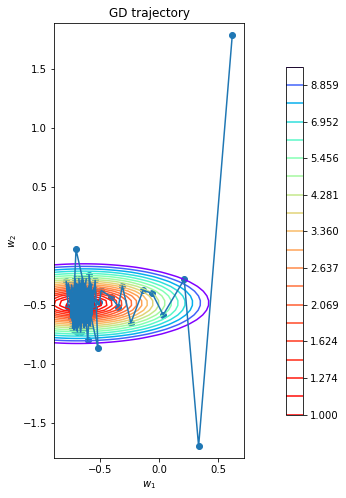

p =  0.001


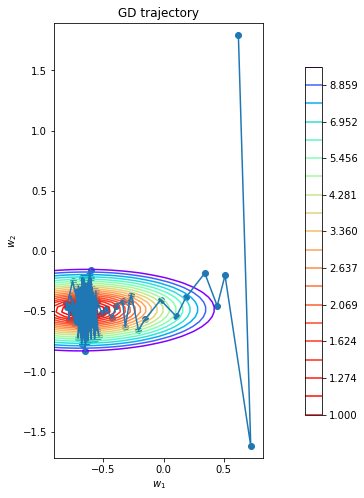

p =  0.01


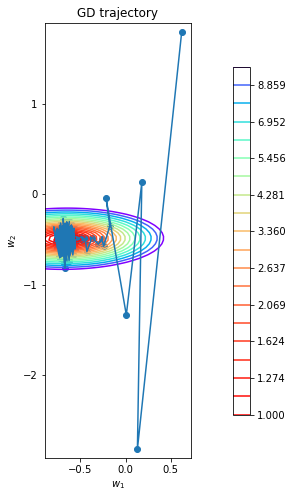

p =  0.011


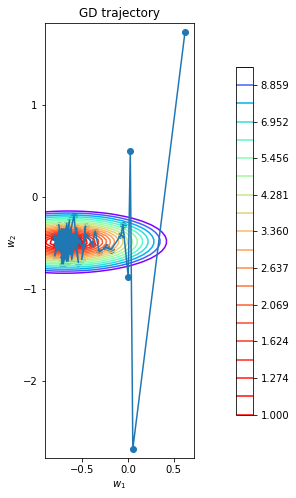

p =  0.1


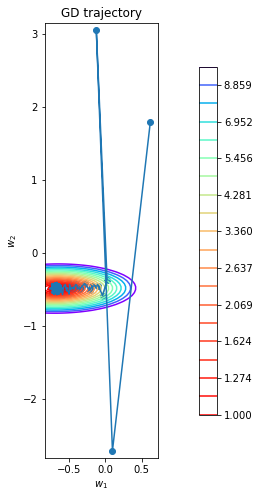

p =  0.3


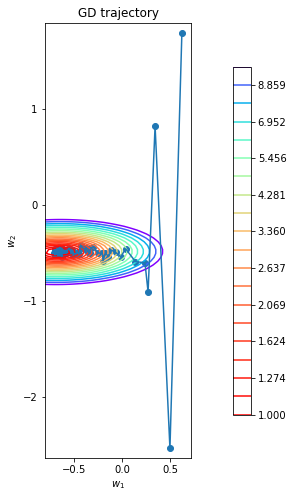

p =  0.5


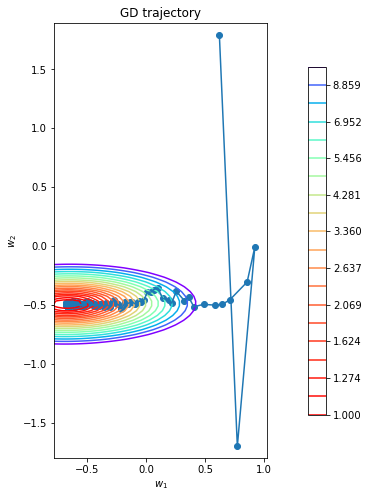

p =  1


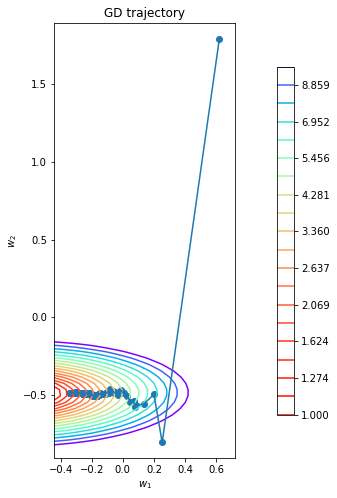

p =  2


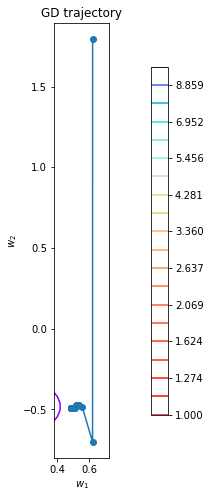

In [13]:
p = [0.0005, 0.001, 0.01, 0.011, 0.1, 0.3, 0.5, 1, 2]
for elem in p:
    trace = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, elem, 1000)
    print('p = ', elem)
    plot_gd(trace, X, y, loss)

При большом значении параметра p градиентный спуск будет очень долго продвигаться к минимуму и может вообще не сойтись к минимуму. При очень маленьком значении параметра p градиентный спуск будет сильно колебаться

<h1>Задание 1.8 (5/8 балла):</h1>

Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

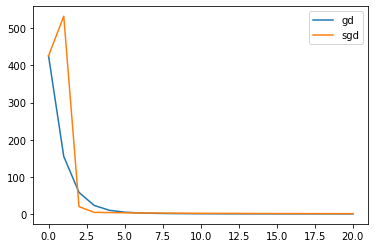

In [14]:
loss = MSELoss()
trace_gd = gradient_descent(w_init, X, y, loss, 0.01, 20)
trace_sgd = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, 0.5, 20)
x = np.arange(21)
y_gd = []
y_sgd = []
for elem in trace_gd:
    y_gd.append(loss.calc_loss(X, y, elem))

for elem in trace_sgd:
    y_sgd.append(loss.calc_loss(X, y, elem))
    
plt.plot(x, y_gd)
plt.plot(x, y_sgd)
plt.legend(['gd', 'sgd'])

На данном графике не видно большое преимущество SGD, вероятно, потому что выборка очень мала.

<h1>Часть 2. Линейная регрессия (5 баллов)</h1>

Теперь давайте напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`

В методе `predict` мы будем применять нашу регрессию к датасету, 

<h1>Задание 2.1 (5/8 балла):</h1>

Допишите код в методах `fit` и `predict` класса `LinearRegression`

В методе `fit` вам нужно как-то инициализировать веса `w`, применить `gradient_descent` и сохранить последнюю `w` из траектории.

В методе `predict` вам нужно применить линейную регрессию и вернуть вектор ответов.

Обратите внимание, что объект лосса передаётся в момент инициализации и хранится в `self.loss`. Его нужно использовать в `fit` для `gradient_descent`.

In [15]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'LinearRegression':
        X = np.asarray(X)
        y = np.asarray(y)
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        
        # -- YOUR CODE HERE --
        w_init = np.random.uniform(-2, 2, (X.shape[1]))
        self.w = gradient_descent(w_init, X, y, self.loss, self.lr, 100)[-1]
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        # Добавляем столбец из единиц для константного признака
        X = np.hstack([X, np.ones([X.shape[0], 1])])
        # -- YOUR CODE HERE --
        return X @ self.w

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации. 

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [16]:
linear_regression = LinearRegression(MSELoss(), 0.01)

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами:

In [45]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data", 
    header=None, 
    na_values=["?"]
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [46]:
X_raw

,index,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,24,25
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0
197,201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,...,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0
198,202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0
199,203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,...,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0


<h1>Задание 2.2 (5/8 балла):</h1>

Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

<ul>
<li>Разделите датасет на обучающую и тестовую выборку</li>
<li>Заполните пропуски</li>
<li>Нормализуйте числовые признаки</li>
<li>Закодируйте категориальные переменные</li>
</ul>

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [52]:
X_raw.isna().sum()

index     0
0         0
1        37
2         0
3         0
4         0
5         2
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        4
19        4
20        0
21        2
22        2
23        0
24        0
25        0
dtype: int64

In [53]:
X_raw[1] = X_raw[1].fillna(X_raw[1].mean())
X_raw[5] = X_raw[5].fillna('')
X_raw[18] = X_raw[18].fillna(X_raw[18].mean())
X_raw[19] = X_raw[19].fillna(X_raw[19].mean())
X_raw[21] = X_raw[21].fillna(X_raw[21].mean())
X_raw[22] = X_raw[22].fillna(X_raw[22].mean())
## заполнение пропусков

In [55]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

In [56]:
X_raw = pd.get_dummies(X_raw, X_raw.describe(include = 'object').columns, drop_first = True)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size = 0.3, random_state = 10)

In [58]:
normalizer = StandardScaler()
normalizer.fit(X_train)
X_train_transformed = normalizer.transform(X_train)
X_test_transformed = normalizer.transform(X_test)

In [59]:
X_raw

,index,0,1,9,10,11,12,13,16,18,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,0,3,122.0,88.6,168.8,64.1,48.8,2548,130,3.47,...,0,0,0,0,0,0,0,1,0,0
1,1,3,122.0,88.6,168.8,64.1,48.8,2548,130,3.47,...,0,0,0,0,0,0,0,1,0,0
2,2,1,122.0,94.5,171.2,65.5,52.4,2823,152,2.68,...,0,0,0,0,0,0,0,1,0,0
3,3,2,164.0,99.8,176.6,66.2,54.3,2337,109,3.19,...,0,0,0,0,0,0,0,1,0,0
4,4,2,164.0,99.4,176.6,66.4,54.3,2824,136,3.19,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,200,-1,95.0,109.1,188.8,68.9,55.5,2952,141,3.78,...,0,0,0,0,0,0,0,1,0,0
197,201,-1,95.0,109.1,188.8,68.8,55.5,3049,141,3.78,...,0,0,0,0,0,0,0,1,0,0
198,202,-1,95.0,109.1,188.8,68.9,55.5,3012,173,3.58,...,0,0,0,0,0,0,0,1,0,0
199,203,-1,95.0,109.1,188.8,68.9,55.5,3217,145,3.01,...,0,0,0,0,0,1,0,0,0,0


<h1>Задание 2.3 (5/8 балла):</h1>

Обучите написанную вами линейную регрессию на обучающей выборке

In [60]:
linear_regression.fit(X_train_transformed, y_train)

<h1>Задание 2.4 (5/8 балла):</h1>

Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке при помощи метода mean_squared_error из sklearn.metrics.

In [61]:
from sklearn.metrics import mean_squared_error
print('MSE train: {}'.format(mean_squared_error(y_train, linear_regression.predict(X_train_transformed))))
print('MSE test: {}'.format(mean_squared_error(y_test, linear_regression.predict(X_test_transformed))))

MSE train: 7380832.67139027
MSE test: 7130292.899323974


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

<h1>Задание 2.5 (5/8 балла):</h1>

Реализуйте класс MSEL2Loss

Он должен вычислять лосс и градиент по формулам наверху

Подсказка: обратите внимание, что последний элемент вектора w — это bias (в классе LinearRegression к матрице X добавляется колонка из единиц — константный признак). Как мы знаем из лекций и семинаров, bias регуляризовать не нужно. Поэтому не забудьте убрать последний элемент из w при подсчёте слагаемого <i>λ||w||^2 </i>
в calc_loss и занулить его при подсчёте слагаемого <i>2λw</i> в calc_grad

In [62]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.):
        """
        :param coef: коэффициент регуляризации (лямбда в формуле)
        """
        self.coef = coef
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета. Последний признак константный.
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии. Последний вес -- bias.
        :output: число -- значения функции потерь
        """
        # -- YOUR CODE HERE --
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        loss = (((1 / X.shape[0]) * abs(X @ w - y)**2).sum() + self.coef * abs(w[:-1])**2).sum()
        
        return loss
        
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # -- YOUR CODE HERE --
        # Вычислите значение вектора градиента при помощи X, y и w и верните его
        w_copy = w.copy()
        w_copy[-1] = 0
        grad = (2 / X.shape[0]) * X.transpose() @ (X @ w - y) + 2 * self.coef * w_copy
        
        return grad
        

<h1>Задание 2.6 (5/8 балла):</h1>

Обучите регрессию с лоссом MSEL2Loss. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [67]:
print('MSE:')
print('train: {}'.format(mean_squared_error(y_train, linear_regression.predict(X_train_transformed))))
print('test: {}\n'.format(mean_squared_error(y_test, linear_regression.predict(X_test_transformed))))

print('MSE2L:')
coef = [0.01, 0.1, 0.5, 0.7, 1, 10]
for elem in coef:
    lr = LinearRegression(MSEL2Loss(elem), 0.01)
    lr.fit(X_train_transformed, y_train)
    print('coef =', elem)
    print('train: {}'.format(mean_squared_error(y_train, lr.predict(X_train_transformed))))
    print('test: {}\n'.format(mean_squared_error(y_test, lr.predict(X_test_transformed))))

#С помощью MSEL2Loss можно добиться улучшения результата, с помощью подбора коэф. 
#Если взять коэф. равный 0.1, то ошибка будет меньше, чем на MSE

MSE:
train: 7380832.67139027
test: 7130292.899323974

MSE2L:
coef = 0.01
train: 7395095.389201149
test: 7128102.866346802

coef = 0.1
train: 7552406.271429045
test: 7159194.935531754

coef = 0.5
train: 8405252.050321233
test: 7469047.417136809

coef = 0.7
train: 8877216.337692237
test: 7680066.22388314

coef = 1
train: 9606366.407895047
test: 8015847.138402422

coef = 10
train: 27635297.84687488
test: 18618999.640744977



В нашем датасете могут быть выбросы. На семинаре вам рассказывали, что с выбросами хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а  выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

<h1>Задание 2.7 (5/8 балла):</h1>

Реализуйте класс HuberLoss

Он должен вычислять лосс и градиент по формулам наверху

In [31]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        """
        :param eps: параметр huber loss из формулы
        """
        self.eps = eps
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """
        Функция для вычислений значения лосса
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: число -- значения функции потерь
        """
        # -- YOUR CODE HERE --
        # Вычислите значение функции потерь при помощи X, y и w и верните его
        loss = 0
        for i in range(X.shape[0]):
            z = X[i] @ w - y[i]
            if (z > -self.eps) and (z < self.eps):
                loss_i = 1/2 * z**2
                loss += loss_i
            else:
                loss_i = self.eps * (abs(z) - 1/2 * self.eps)
                loss += loss_i
        loss = (1 / X.shape[0]) * loss
        
        return loss
    
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """
        Функция для вычислений градиента лосса по весам w
        :param X: np.ndarray размера (n_objects, n_features) с объектами датасета
        :param y: np.ndarray размера (n_objects,) с правильными ответами
        :param w: np.ndarray размера (n_features,) с весами линейной регрессии
        :output: np.ndarray размера (n_features,) градиент функции потерь по весам w
        """
        # -- YOUR CODE HERE --
        # Вычислите значение вектора градиента при помощи X, y и w и верните его
        grad = 0
        for i in range(X.shape[0]):
            z = X[i] @ w - y[i]
            if (z > -self.eps) and (z < self.eps):
                grad_i = z
                grad += grad_i
            else:
                grad_i = self.eps * np.sign(z)
                grad += grad_i
        grad = (1 / X.shape[0]) * grad
        
        return grad        

<h1>Задание 2.8 (5/8 балла):</h1>

Обучите регрессию с лоссом HuberLoss. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c MSELoss.

In [32]:
coef = [0.01, 0.1, 0.5, 0.7, 1, 10]
for elem in coef:
    huber = LinearRegression(HuberLoss(elem), 0.01)
    huber.fit(X_train_transformed, y_train)
    print('coef =', elem)
    print('train: {}'.format(mean_squared_error(y_train, huber.predict(X_train_transformed))))
    print('test: {}\n'.format(mean_squared_error(y_test, huber.predict(X_test_transformed))))

coef = 0.01
train: 248132548.57677442
test: 226752790.72377303

coef = 0.1
train: 247898661.22221115
test: 226574353.54631323

coef = 0.5
train: 247860620.00493395
test: 226440619.3071855

coef = 0.7
train: 248024933.09152886
test: 226742395.49562585

coef = 1
train: 247967601.67466068
test: 226519771.46216103

coef = 10
train: 246971830.61464268
test: 225566698.9591783



Как мы можем заметить ошибка на HuberLoss значительно больше, чем на MSELoss. Вероятно, это из-за того, что количество выбросов очень большое